## Cervical Cancer Risk Factors

Cervical cancer is one of the top listed female cancers worldwide. According to WHO, in 2018, an estimated 570000 women were diagnosed and out of them 311000 died. However, cervical cancer is also one of the most treatable forms of cancer. In this study, the major risk factors of cervical cancer are being assessed. 

**Importing required libraries**

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedShuffleSplit
from typing import List
from sklearn.preprocessing import RobustScaler,StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_recall_fscore_support
from imblearn.over_sampling import SMOTE, ADASYN
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.offline import plot, iplot, init_notebook_mode
init_notebook_mode(connected=True)
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")


**Preprocessing**

In [67]:
risk_factor_df = pd.read_csv("kag_risk_factors_cervical_cancer.csv")
risk_factor_df.head()

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs: Time since first diagnosis,STDs: Time since last diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
0,18,4.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,?,?,0,0,0,0,0,0,0,0
1,15,1.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,?,?,0,0,0,0,0,0,0,0
2,34,1.0,?,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,?,?,0,0,0,0,0,0,0,0
3,52,5.0,16.0,4.0,1.0,37.0,37.0,1.0,3.0,0.0,...,?,?,1,0,1,0,0,0,0,0
4,46,3.0,21.0,4.0,0.0,0.0,0.0,1.0,15.0,0.0,...,?,?,0,0,0,0,0,0,0,0


In [68]:
risk_factor_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 858 entries, 0 to 857
Data columns (total 36 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   Age                                 858 non-null    int64 
 1   Number of sexual partners           858 non-null    object
 2   First sexual intercourse            858 non-null    object
 3   Num of pregnancies                  858 non-null    object
 4   Smokes                              858 non-null    object
 5   Smokes (years)                      858 non-null    object
 6   Smokes (packs/year)                 858 non-null    object
 7   Hormonal Contraceptives             858 non-null    object
 8   Hormonal Contraceptives (years)     858 non-null    object
 9   IUD                                 858 non-null    object
 10  IUD (years)                         858 non-null    object
 11  STDs                                858 non-null    object

In [69]:
cols_to_convert = ['Number of sexual partners', 'First sexual intercourse', 'Num of pregnancies', 'Smokes',
                   'Smokes (years)', 'Smokes (packs/year)', 'Hormonal Contraceptives',
                   'Hormonal Contraceptives (years)', 'IUD', 'IUD (years)', 'STDs', 'STDs (number)',
                   'STDs:condylomatosis', 'STDs:cervical condylomatosis', 'STDs:vaginal condylomatosis',
                   'STDs:vulvo-perineal condylomatosis', 'STDs:syphilis', 'STDs:pelvic inflammatory disease',
                   'STDs:genital herpes', 'STDs:molluscum contagiosum', 'STDs:AIDS', 'STDs:HIV', 'STDs:Hepatitis B',
                   'STDs:HPV', 'STDs: Time since first diagnosis',
                   'STDs: Time since last diagnosis']

risk_factor_df[cols_to_convert] = risk_factor_df[cols_to_convert].apply(pd.to_numeric, errors="coerce")
risk_factor_df[cols_to_convert].fillna(np.nan, inplace=True)
imp = SimpleImputer(strategy="median")
X = imp.fit_transform(risk_factor_df)
risk_factor_df = pd.DataFrame(X, columns=list(risk_factor_df.columns))

In [70]:
def age_cat(age):
    if age < 12:
        return "Child"
    elif age < 20:
        return "Teens"
    elif age < 30:
        return "20s"
    elif age < 40:
        return "30s"
    elif age < 50:
        return "40s"
    elif age < 60:
        return "50s"
    else:
        return "Senior"

risk_factor_df["Age"] = risk_factor_df["Age"].astype(int)
risk_factor_df["age_cat"] = risk_factor_df["Age"].apply(age_cat)

In [71]:
std_cols = {'STDs:condylomatosis',
            'STDs:cervical condylomatosis',
            'STDs:vaginal condylomatosis',
            'STDs:vulvo-perineal condylomatosis',
            'STDs:syphilis',
            'STDs:pelvic inflammatory disease',
            'STDs:genital herpes',
            'STDs:molluscum contagiosum',
            'STDs:AIDS',
            'STDs:HIV',
            'STDs:Hepatitis B',
            'STDs:HPV'}

risk_factor_df["total_std"] = risk_factor_df[list(std_cols)].sum(axis=1)
std_agg = risk_factor_df.groupby("age_cat", as_index=False)[list(std_cols)].sum()

In [72]:
test_cols = ["Hinselmann", "Schiller", "Citology", "Biopsy"]
risk_factor_df["total_tests"] = risk_factor_df[test_cols].sum(axis = 1)

In [73]:
risk_factor_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 858 entries, 0 to 857
Data columns (total 39 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Age                                 858 non-null    int32  
 1   Number of sexual partners           858 non-null    float64
 2   First sexual intercourse            858 non-null    float64
 3   Num of pregnancies                  858 non-null    float64
 4   Smokes                              858 non-null    float64
 5   Smokes (years)                      858 non-null    float64
 6   Smokes (packs/year)                 858 non-null    float64
 7   Hormonal Contraceptives             858 non-null    float64
 8   Hormonal Contraceptives (years)     858 non-null    float64
 9   IUD                                 858 non-null    float64
 10  IUD (years)                         858 non-null    float64
 11  STDs                                858 non-n

In [74]:
int_cols = {"total_tests",
                     "total_std",
                     "Smokes",
                     "Biopsy",
                     "Dx:Cancer",
                     "Num of pregnancies",
                     "Number of sexual partners",
                     "First sexual intercourse",
                     "Hormonal Contraceptives",
                     "IUD",
                     "STDs",
                     "STDs (number)",
                     "STDs: Number of diagnosis",
                     "Dx:CIN",
                     "Dx:HPV",
                     "Dx",
                     "Hinselmann",
                     "Schiller", "Biopsy","Citology"}
int_cols = int_cols.union(std_cols)

for col in int_cols:
    risk_factor_df[col] = risk_factor_df[col].astype(int)

In [75]:
n = 7
target = "Dx:Cancer"
corr = risk_factor_df.select_dtypes(include=np.number).corr()

x = corr.nlargest(n,target).index
corr_df =  risk_factor_df[list(x)]
corr = corr_df.corr()
fig = px.imshow(corr,color_continuous_scale = "PuBu")
fig.update_layout(title="Top "+str(n)+" Features Correlated With "+str(target).capitalize())
fig.show()

**Using ADASYN to fix imbalanced classes**

In [76]:
dx_cancer = px.histogram(risk_factor_df, y="Dx:Cancer")
dx_cancer.update_layout(bargap=0.2)
dx_cancer.update_layout(title = "Imbalanced Classes")
dx_cancer.show()

In [77]:
X = risk_factor_df.drop(["Dx:Cancer", "age_cat"], axis=1)
y = risk_factor_df["Dx:Cancer"].copy()

In [78]:
adasyn = ADASYN(random_state=42)
x_adasyn,y_adasyn = adasyn.fit_resample(X,y)
risk_factor_df = x_adasyn.join(y_adasyn)

In [79]:
risk_factor_df["age_cat"] = risk_factor_df["Age"].apply(age_cat)

In [80]:
dx_cancer = px.histogram(risk_factor_df, y="Dx:Cancer")
dx_cancer.update_layout(bargap=0.2)
dx_cancer.update_layout(title = "Balanced Classes")
dx_cancer.show()

**Train-test Split**

In [86]:
train_set = None
test_set = None 
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in split.split(risk_factor_df, risk_factor_df['age_cat']):
    train_set = risk_factor_df.loc[train_idx]
    test_set = risk_factor_df.loc[test_idx]
cols_to_drop = ['age_cat',"total_std","total_tests"]
for set_ in (train_set, test_set):
    for col in cols_to_drop:
        set_.drop(col, axis=1, inplace=True)

In [87]:
X_train = train_set.drop("Dx:Cancer", axis=1)
y_train = train_set["Dx:Cancer"].copy()

X_test = test_set.drop("Dx:Cancer", axis=1)
y_test = test_set["Dx:Cancer"].copy()

In [83]:
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" 

### Modeling

**1. Logistic Regression**

In [88]:
C_param_range = [0.001,0.01,0.1,1]

lr_scores = pd.DataFrame(columns = ['C_parameter','Accuracy'])
lr_scores['C_parameter'] = C_param_range


j = 0
for i in C_param_range:
    
    # Apply logistic regression model to training data
    Logreg = LogisticRegression(penalty = 'l2', C = i,random_state = 40)
    Logreg.fit(X_train,y_train)
    
    # Predict using model
    y_pred_lr = Logreg.predict(X_test)
    
    # Saving accuracy score in table
    lr_scores.iloc[j,1] = accuracy_score(y_test,y_pred_lr)
    j += 1
    
lr_scores   

,C_parameter,Accuracy
0,0.001,0.708333
1,0.010,0.964286
2,0.100,0.988095
3,1.000,0.991071


In [89]:
from sklearn.metrics import plot_confusion_matrix
cnf_matrix_lr = confusion_matrix(y_test, y_pred_lr_cv)

print(cnf_matrix_lr)

[[172   3]
 [  0 161]]


**2. Random Forest Classifier**

In [90]:
rnd_clf = RandomForestClassifier(n_estimators=2500, max_leaf_nodes=2, n_jobs=-1,
                                 max_features="sqrt")

In [91]:
rnd_clf.fit(X_train,y_train)
y_pred_rf = rnd_clf.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(accuracy_rf)

0.9940476190476191


**3. K-NearestNeighbors**

In [96]:
knn_clf = KNeighborsClassifier()
knn_param_grid = {"n_neighbors": list(np.arange(1, 100, 2))}
knn_clf_cv = GridSearchCV(knn_clf, knn_param_grid, cv=5,refit=True).fit(X_train,y_train)
knn_clf_cv = KNeighborsClassifier(**knn_clf_cv.best_params_)

In [100]:
knn_clf_cv.fit(X_train, y_train)
y_pred_knn = knn_clf_cv.predict(X_test)

accuracy_knn = accuracy_score(y_test,y_pred_knn)
print(accuracy_knn)

0.9613095238095238


**4. SVM**

In [93]:
svm_clf = SVC()
svc_param_grid = {'C': np.logspace(-3, 2, 6), 'gamma': np.logspace(-3, 2, 6), }
svm_clf_cv = GridSearchCV(svm_clf, svc_param_grid, cv=5)

In [101]:
svm_clf_cv.fit(X_train,y_train)
y_pred_svm = svm_clf_cv.predict(X_test)
accuracy_svm = accuracy_score(y_test,y_pred_svm)

print(accuracy_svm)

0.9970238095238095


**Predicting and calculating model scores**

In [102]:
col_names = ["Classifier Name", "Accuracy Score", "Precision Score",
             "Recall Score", "F1 Score"]
summary_df = pd.DataFrame(columns=col_names)

est_name = []
est_acc = []
precision_score = []
recall_score = []
f1score = []
est_conf_matrix = []


estimators = [
    ("LogisticRegression", Logreg),
    ("RandomForestClassifier ", rnd_clf),
    ("KNeighborsClassifier", knn_clf_cv),
    ("SupportVectorClassifier", svm_clf_cv)]

for i in range(0, len(estimators)):
    clf = estimators[i][1]
    clf_name = estimators[i][0]
    y_pred = clf.predict(X_test)
    est_name.append(estimators[i][0])
    est_acc.append(accuracy_score(y_test, y_pred))
    scores = precision_recall_fscore_support(y_test, y_pred, average="weighted")
    precision_score.append(scores[0])
    recall_score.append(scores[1])
    f1score.append(scores[2])
    est_conf_matrix.append(confusion_matrix(y_test,y_pred))  
    
summary_df[col_names[0]] = est_name
summary_df[col_names[1]] = est_acc
summary_df[col_names[2]] = precision_score
summary_df[col_names[3]] = recall_score
summary_df[col_names[4]] = f1score

print(summary_df)

           Classifier Name  Accuracy Score  Precision Score  Recall Score  \
0       LogisticRegression        0.991071         0.991235      0.991071   
1  RandomForestClassifier         0.994048         0.994048      0.994048   
2     KNeighborsClassifier        0.961310         0.964200      0.961310   
3  SupportVectorClassifier        0.997024         0.997042      0.997024   

   F1 Score  
0  0.991074  
1  0.994048  
2  0.961314  
3  0.997024  


In [103]:
color_scales = ["agsunset","teal","purp","viridis","ice"]
for i in range(0,len(est_conf_matrix)):
    heatmap = px.imshow(est_conf_matrix[i],aspect="auto",
                        text_auto=True,
                        color_continuous_scale=color_scales[i])
    heatmap.update_layout(title = est_name[i])
    heatmap.update_xaxes(title="Predicted")
    heatmap.update_yaxes(title="Actual")
    heatmap.show()

**Hyperparameter tuning for the Random Forest Classifier**

In [104]:
from sklearn.model_selection import GridSearchCV

rf_cv = RandomForestClassifier(max_features='auto',random_state=1, n_jobs=-1)

param_grid = { "criterion" : ["gini", "entropy"], "min_samples_leaf" : [1, 5, 10], "min_samples_split" : [2, 4, 10,12,16], "n_estimators": [50, 100,400,700,1000]}

gs = GridSearchCV(estimator=rf_cv, param_grid=param_grid, scoring='accuracy', cv=3, n_jobs=-1)

gs = gs.fit(X_train, y_train)

print(gs.best_estimator_) 
print(gs.best_score_)

RandomForestClassifier(criterion='entropy', max_features='auto',
                       n_estimators=50, n_jobs=-1, random_state=1)
0.9992542878448919


Feature Importance

Feature: 0, Score: 0.08880
Feature: 1, Score: 0.01640
Feature: 2, Score: 0.08560
Feature: 3, Score: 0.01760
Feature: 4, Score: 0.06600
Feature: 5, Score: 0.00360
Feature: 6, Score: 0.01280
Feature: 7, Score: 0.03320
Feature: 8, Score: 0.07320
Feature: 9, Score: 0.00480
Feature: 10, Score: 0.10920
Feature: 11, Score: 0.04840
Feature: 12, Score: 0.04680
Feature: 13, Score: 0.02400
Feature: 14, Score: 0.00000
Feature: 15, Score: 0.00040
Feature: 16, Score: 0.02160
Feature: 17, Score: 0.00360
Feature: 18, Score: 0.00000
Feature: 19, Score: 0.00000
Feature: 20, Score: 0.00000
Feature: 21, Score: 0.00000
Feature: 22, Score: 0.00080
Feature: 23, Score: 0.00000
Feature: 24, Score: 0.00000
Feature: 25, Score: 0.03480
Feature: 26, Score: 0.01640
Feature: 27, Score: 0.01080
Feature: 28, Score: 0.00120
Feature: 29, Score: 0.14600
Feature: 30, Score: 0.12200
Feature: 31, Score: 0.00080
Feature: 32, Score: 0.00680
Feature: 33, Score: 0.00280
Feature: 34, Score: 0.00160


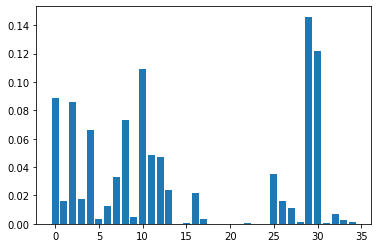

In [106]:
importance = rnd_clf.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()